On implémente le modèle SVM. D'abord, on importe les bibliothèques nécessaires.

In [2]:
# Importer les bibliothèques nécessaires

# Pour manipuler les bases de données et les graphes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Pour le ML
# from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer


Ensuite, on charge la base de données, et on la retravaille.

In [16]:
# Charger le jeu de données
path = "/home/onyxia/work/statapp_sujet26/"
#enlever work si nécessaire
file_name1 = "dataset_complet_part_1.csv"
file_name2 = "dataset_complet_part_2.csv"
df1 = pd.read_csv(path+file_name1, sep=',',low_memory=False)
df2 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df = pd.concat([df1,df2])

df = df.loc[df['an'] == 2019]
df['grav'] = df['grav'].replace({1:0,2:0,3:1,4:1})

df = df.drop(columns=['Num_Acc','an','adr','lat','long','lartpc','larrout','com','gps','voie','v2','pr','pr1','dep'])
#ici on enlève an car on ne regarde que pour 2019
df['hrmn'] = df['hrmn'].str.split(':').str[0]
df['hrmn'] = df['hrmn'].astype(int)

# Convertir les colonnes jour et mois en format de date
df['date'] = pd.to_datetime({'year': 2019, 'month': df['mois'], 'day': df['jour']})

# Obtenir le jour de la semaine à partir de la colonne date
df['jour_de_semaine'] = df['date'].dt.day_name()
df = pd.get_dummies(df, columns=['jour_de_semaine'], prefix='jour', dtype=int)
df = df.drop(columns=['date','jour'])

df['mois'] = df['mois'].replace({1.:'janvier',2.:'février',3.:'mars',4.:'avril',5.:'mai',6.:'juin',7.:'juillet',8.:'août',9.:'septembre',10.:'octobre',11.:'novembre',12.:'décembre'})
df = pd.get_dummies(df, columns=['mois'], prefix='mois', dtype=int)

# Créer une fonction pour mapper les heures à des plages horaires
def plage_horaire(heure):
    if 5 <= heure < 12:
        return 'matin'
    elif 12 <= heure < 14:
        return 'midi'
    elif 14 <= heure < 18:
        return 'après-midi'
    elif 18 <= heure < 22:
        return 'soir'
    else:
        return 'nuit'

# Appliquer la fonction à la colonne heure pour créer une nouvelle colonne plage_horaire
df['plage_horaire'] = df['hrmn'].apply(plage_horaire)
df = pd.get_dummies(df, columns=['plage_horaire'], prefix='plage_horaire', dtype=int)

df = df.drop(columns=['hrmn'])

df.to_csv('svm.csv', index=False)

y = df['grav']
X = df.drop(columns=['grav'])
features = X.columns

In [17]:
print(X.head())
print(y.head())
print(features)

        lum  agg  int  atm  col  catr   v1  circ nbv  vosp  ...  mois_mai  \
362128  4.0  1.0  1.0  1.0  2.0   1.0  0.0   3.0  10   0.0  ...         0   
362129  3.0  1.0  1.0  1.0  6.0   1.0  0.0   1.0   2   0.0  ...         0   
362130  1.0  1.0  1.0  1.0  4.0   1.0  0.0   3.0   8   0.0  ...         0   
362131  5.0  1.0  1.0  1.0  4.0   1.0  0.0   3.0   5   0.0  ...         0   
362132  3.0  1.0  1.0  1.0  2.0   1.0  0.0   1.0   3   0.0  ...         0   

        mois_mars  mois_novembre  mois_octobre  mois_septembre  \
362128          0              1             0               0   
362129          0              1             0               0   
362130          0              1             0               0   
362131          0              1             0               0   
362132          0              1             0               0   

        plage_horaire_après-midi  plage_horaire_matin  plage_horaire_midi  \
362128                         0                    0          

In [18]:
# Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Créer un objet imputer
imputer = SimpleImputer(strategy='mean')
# On impute la moyenne arbitrairement

# Appliquer l'imputation aux données d'entraînement
X_train = imputer.fit_transform(X_train)

# Appliquer l'imputation aux données de test
X_test = imputer.transform(X_test)

# Normaliser les fonctionnalités (pour la mise à l'échelle)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
# Créer un classifieur SVM
svm_classifier = SVC(kernel='linear', random_state=42)

In [20]:
# Entraîner le modèle SVM
svm_classifier.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = svm_classifier.predict(X_test)

In [21]:
# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7025266258780875


On regarde enfin l'importance de chaque feature.

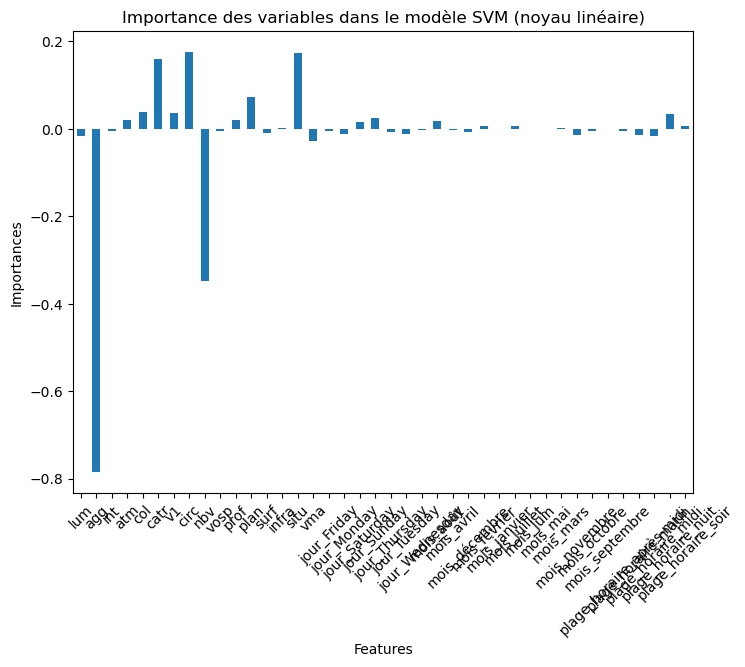

In [22]:
coefficients = pd.Series(svm_classifier.coef_[0], index=features)

# Afficher les coefficients sur un graphe
plt.figure(figsize=(8, 6))
coefficients.plot(kind='bar')
plt.title('Importance des variables dans le modèle SVM (noyau linéaire)')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation=45)
plt.show()